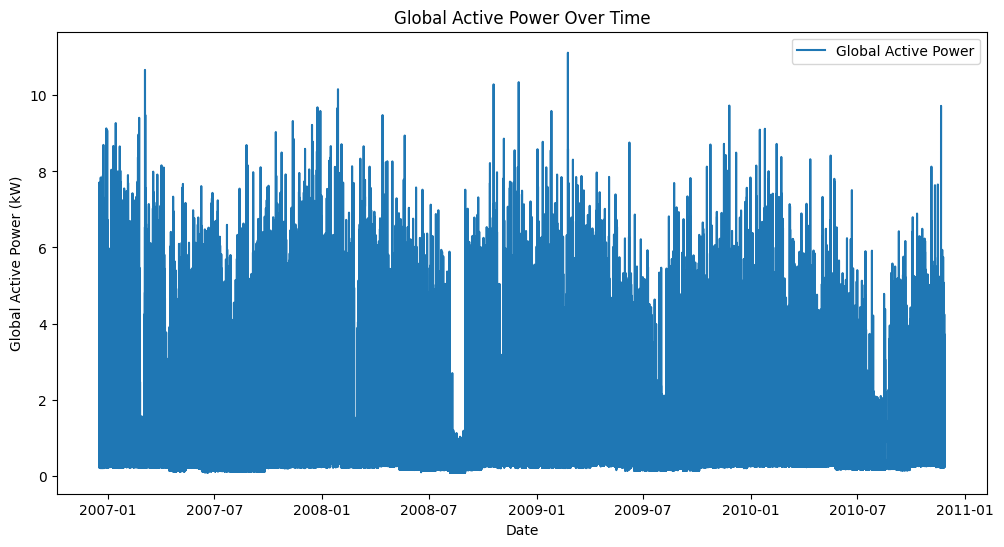

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading the cleaned dataset
data_path = '../data/cleaned_household_power_consumption.csv'
df = pd.read_csv(data_path, parse_dates=['DateTime'], index_col='DateTime')

data = df[['Global_active_power']]

# plotting the data before modeling
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Global_active_power'], label='Global Active Power')
plt.title('Global Active Power Over Time')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

In [2]:
# Selecting only relevant columns for prediction
# Including other features such as Voltage, Global_intensity, and sub-metering values
features = ['Global_active_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
df = df[features]

# training and testing data split (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Feature scaling
# fit scaler on training data only, and transform both train and test
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

#converting scaled data back to DataFrames for easier handling
train_scaled = pd.DataFrame(train_scaled, columns=features, index=train.index)
test_scaled = pd.DataFrame(test_scaled, columns=features, index=test.index)

print("Scaled Training Data:")
print(train_scaled.head())

print("\nScaled Testing Data:")
print(test_scaled.head())

Scaled Training Data:
                     Global_active_power   Voltage  Global_intensity  \
DateTime                                                               
2006-12-16 17:24:00             0.374796  0.376090          0.377593   
2006-12-16 17:25:00             0.478363  0.336995          0.473029   
2006-12-16 17:26:00             0.479631  0.326010          0.473029   
2006-12-16 17:27:00             0.480898  0.340549          0.473029   
2006-12-16 17:28:00             0.325005  0.403231          0.323651   

                     Sub_metering_1  Sub_metering_2  Sub_metering_3  
DateTime                                                             
2006-12-16 17:24:00             0.0          0.0125        0.548387  
2006-12-16 17:25:00             0.0          0.0125        0.516129  
2006-12-16 17:26:00             0.0          0.0250        0.548387  
2006-12-16 17:27:00             0.0          0.0125        0.548387  
2006-12-16 17:28:00             0.0          0.0125  

Naive Model RMSE: 0.2171


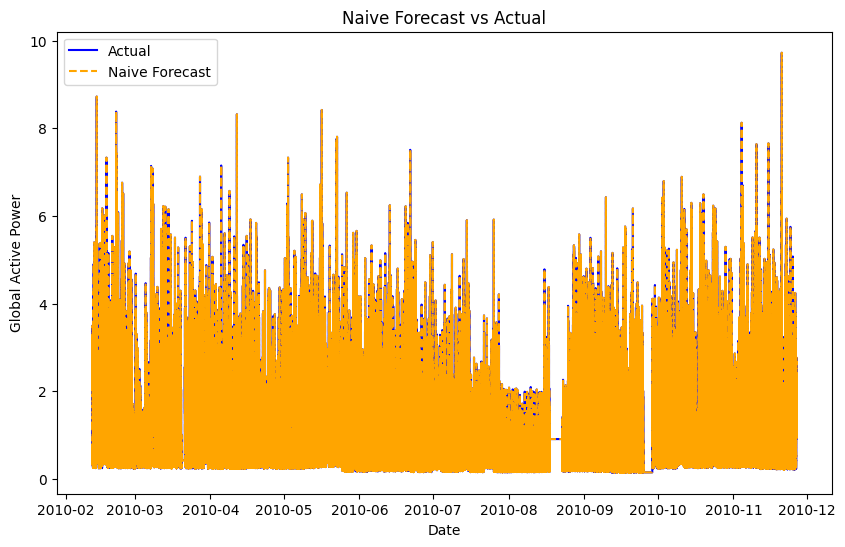

In [4]:
from sklearn.metrics import mean_squared_error

# Baseline Naive Model
naive_forecast = test['Global_active_power'].shift(1).dropna()

#calculating RMSE
naive_rmse = np.sqrt(mean_squared_error(test['Global_active_power'][1:], naive_forecast))

print(f"Naive Model RMSE: {naive_rmse:.4f}")

# Plotting Naive Forecast vs Actuals
plt.figure(figsize=(10, 6))
plt.plot(test.index[1:], test['Global_active_power'][1:], label='Actual', color='blue')
plt.plot(test.index[1:], naive_forecast, label='Naive Forecast', linestyle='--', color='orange')
plt.title('Naive Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on 'Global_active_power' to check for stationarity
result = adfuller(train['Global_active_power'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value}")

# Interpret the p-value to determine stationarity
if result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary. Differencing is required.")

# ISSUE FACED! THE ABOVE CODE IS GIVING "MemoryError" (even in colab notebook) due to the large dataset size causing the ADF test and possibly the ARIMA model fitting process to consume too much memory

MemoryError: Unable to allocate 785. MiB for an array with shape (62, 1660069) and data type float64

In [6]:
# So, I am downsampling to daily frequency
train_daily = train['Global_active_power'].resample('D').mean()
test_daily = test['Global_active_power'].resample('D').mean()

# drop NaN values after resampling
train_daily = train_daily.dropna()
test_daily = test_daily.dropna()


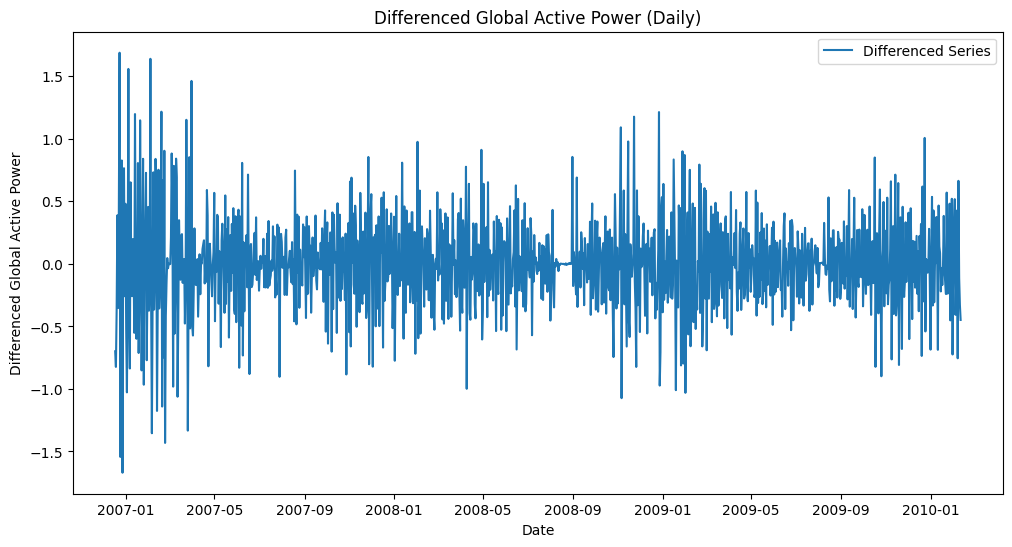

In [9]:
# Instead of the ADF test (which still uses too much memory), I am directly applying first-order differencing to make the series stationary
train_diff = train_daily.diff().dropna()

# plotting the differenced data to visually check for stationarity
plt.figure(figsize=(12, 6))
plt.plot(train_diff, label="Differenced Series")
plt.title("Differenced Global Active Power (Daily)")
plt.xlabel("Date")
plt.ylabel("Differenced Global Active Power")
plt.legend()
plt.show()


In [ ]:
# NOW, we cancConfigure and fit the ARIMA Model on downsampled data
    # taking initial values for (p, d, q) as (1, 1, 1)
# from statsmodels.tsa.arima.model import ARIMA

# # fit ARIMA model on downsampled data
# model = ARIMA(train_daily, order=(1, 1, 1))
# arima_model = model.fit()

# print(arima_model.summary())

# note: we want lower values for AIC & BIC - indicates better model
# Also, iska RMSE is also 0.5608 (higher than 2, 0, 2)

                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                 1154
Model:                  ARIMA(1, 1, 1)   Log Likelihood                -329.318
Date:                 Thu, 07 Nov 2024   AIC                            664.636
Time:                         21:29:41   BIC                            679.786
Sample:                     12-16-2006   HQIC                           670.354
                          - 02-11-2010                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2342      0.027      8.639      0.000       0.181       0.287
ma.L1         -0.8864      0.015    -58.128      0.000      -0.916      -0.857
sigma2         0.1036      0.003     30.735 

In [ ]:
# THUS, FOR BETTER ARIMA MODEL PARAMS, I am using grid search with a set range for (p, d, q) values (0 to 3)
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_order = None
best_model = None

warnings.filterwarnings("ignore")

# performing grid search!
for order in pdq:
    try:
        model = ARIMA(train_daily, order=order)
        arima_result = model.fit()
        
        # Compare AIC values
        if arima_result.aic < best_aic:
            best_aic = arima_result.aic
            best_order = order
            best_model = arima_result
    except:
        continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
print(best_model.summary())


Best ARIMA order: (2, 0, 2) with AIC: 643.5768852043011
                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                 1154
Model:                  ARIMA(2, 0, 2)   Log Likelihood                -315.788
Date:                 Thu, 07 Nov 2024   AIC                            643.577
Time:                         21:23:42   BIC                            673.883
Sample:                     12-16-2006   HQIC                           655.015
                          - 02-11-2010                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1735      0.125      9.384      0.000       0.928       1.419
ar.L1          0.7369      0.089      8.324      0.000       0.563 

In [ ]:
# THEREFORE! ARIMA order (2, 0, 2) is better than (1 ,1 ,1) order!

In [12]:
from statsmodels.tsa.arima.model import ARIMA

# fit ARIMA model on downsampled data
model = ARIMA(train_daily, order=(2, 0, 2))
arima_model = model.fit()

print(arima_model.summary())

                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                 1154
Model:                  ARIMA(2, 0, 2)   Log Likelihood                -315.788
Date:                 Thu, 07 Nov 2024   AIC                            643.577
Time:                         21:27:39   BIC                            673.883
Sample:                     12-16-2006   HQIC                           655.015
                          - 02-11-2010                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1735      0.125      9.384      0.000       0.928       1.419
ar.L1          0.7369      0.089      8.324      0.000       0.563       0.910
ar.L2          0.2456      0.086      2.869 

In [ ]:
# Forecast
forecast = arima_model.forecast(steps=len(test_daily))

#calculating RMSE
from sklearn.metrics import mean_squared_error
arima_rmse = np.sqrt(mean_squared_error(test_daily, forecast))
print(f"ARIMA Model RMSE (Daily): {arima_rmse:.4f}")


ARIMA Model RMSE (Daily): 0.3884


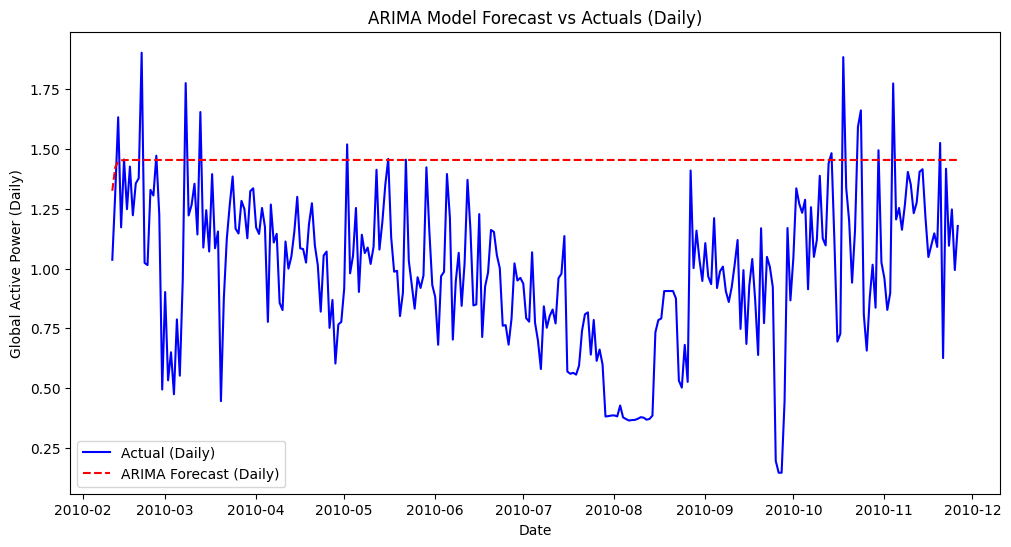

In [17]:
# Visualizing ARIMA Forecasts vs Actuals (Daily Data)
plt.figure(figsize=(12, 6))
plt.plot(test_daily.index, test_daily, label='Actual (Daily)', color='blue')
plt.plot(test_daily.index, forecast, label='ARIMA Forecast (Daily)', color='red', linestyle='--')
plt.title('ARIMA Model Forecast vs Actuals (Daily)')
plt.xlabel('Date')
plt.ylabel('Global Active Power (Daily)')
plt.legend()
plt.show()


In [ ]:
# In the above plot, I can clearly see that ARIMA forecast here produces a relatively flat line, indicating that the model may not fully capture the dynamics of the data.

# Thus, to incorporate Seasonality, I will try out using SARIMA

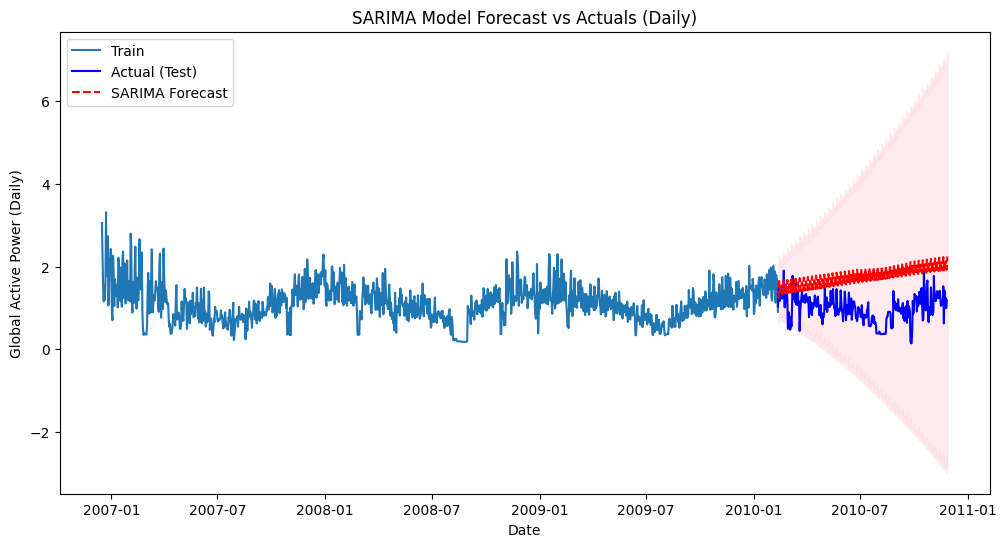

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA with weekly seasonality (assuming S=7 for weekly)
model_sarima = SARIMAX(train_daily, order=(2, 1, 2), seasonal_order=(1, 1, 1, 7))
result_sarima = model_sarima.fit()

# SARIMA Forecast
forecast_sarima = result_sarima.get_forecast(steps=len(test_daily))
forecast_ci_sarima = forecast_sarima.conf_int()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_daily, label='Train')
plt.plot(test_daily, color='blue', label='Actual (Test)')
plt.plot(forecast_sarima.predicted_mean, color='red', linestyle='--', label='SARIMA Forecast')
plt.fill_between(forecast_ci_sarima.index, 
                 forecast_ci_sarima.iloc[:, 0], 
                 forecast_ci_sarima.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Global Active Power (Daily)')
plt.title('SARIMA Model Forecast vs Actuals (Daily)')
plt.legend()
plt.show()


In [ ]:
# we can see, SARIMA model is providing a slight improvement over previous ARIMA Forecast.